# GLV with saturation of interactions

#### Loading libraries

In [1]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import scipy as sc
from scipy.optimize import fsolve
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colormaps

#### Plot settings

In [2]:
#tableau for plots
plt.style.use('tableau-colorblind10')

#colormap
cmap = plt.get_cmap('viridis')   #Blues

#set plot size
plt.rcParams["figure.autolayout"] = True

plt.rcParams['font.size'] = 10   # Default font size for text
plt.rcParams['axes.titlesize'] = 10   # Font size for axes titles
plt.rcParams['axes.labelsize'] = 11 # Font size for x and y labels
plt.rcParams['xtick.labelsize'] = 9 # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 9 # Font size for y tick labels


#set-up the font as in latex
plt.rcParams.update({
    "font.size": 10,
    "font.family": "serif",
    "font.serif": "cmr10",
    "mathtext.fontset": "cm",
    "axes.formatter.use_mathtext": True
})

#available styles
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


#### Paths placeholders

In [3]:
#placeholders for the data
folder_to_save_data = '/home/zenari/glv/data_final_plots/'
folder_to_save_results = '/home/zenari/glv/results/'

#### Definition of utility functions

In [4]:
#saturating function
def J(x, K):
    return np.array(x/(1+K*x))

#NB: 1/K is the saturating value of the function

#derivative of the saturating function
def dJdx(x, K):
    return np.array(1/(1+K*x)**2)


#sample the interaction matrix
def inter_matrix(N, mu, sigma, gamma):
      
    alpha = np.zeros([N, N]) #matrix of interactions

    for i in range(N):
        for j in range(i+1, N):
            z = np.random.normal(size = 2)
            alpha[i, j] = mu/N+sigma/np.sqrt(N)*z[0]
            alpha[j, i] = mu/N+sigma/np.sqrt(N)*(gamma*z[0]+np.sqrt(1-gamma**2)*z[1])
    
    return alpha

#dynamics
def dynamics(x, t, S, mu, sigma, gamma, K, mig, alpha):
    return x*(1-x)+x*np.dot(alpha, J(x, K))+mig


#SELF CONSISTENT EQAUTIONS OF STATIONARY DMFT

#normal distributiion
def P_z(z):
    return 1/np.sqrt(2*np.pi)*np.exp(-z**2/2)

#derivative of the stationary solution
def f_prim(z, Q, q, chi, mu, sigma, gamma, K):
    eta = np.sqrt(q)*sigma*z
    t = 1+mu*Q+eta
    y = 1-gamma*sigma**2*chi
    return 2*t*(K-(4*K-2*K*(y-K*t))/(2*np.sqrt((y-K*t)**2+4*K*t)))/(K*t-y-np.sqrt((y-K*t)**2+4*K*t))**2-2/(K*t-y-np.sqrt((y-K*t)**2+4*K*t))

#stationary value of x given z
def x_z(z, Q, q, chi, mu, sigma, gamma, K):
    eta = np.sqrt(q)*sigma*z
    t = 1+mu*Q+eta
    y = 1-gamma*sigma**2*chi
    return -2*t/(K*t-y-np.sqrt((K*t-y)**2+4*K*t))

#integration boundary
def Delta(Q, q, mu, sigma):
    return (1+mu*Q)/(np.sqrt(q)*sigma)

#equation for Q
def integrand0(z, Q, q, chi, mu, sigma, gamma, K):
    return P_z(z)*J(x_z(z, Q, q, chi, mu, sigma, gamma, K), K)
    
#equation for q
def integrand1(z, Q, q, chi, mu, sigma, gamma, K):
    return P_z(z)*J(x_z(z, Q, q, chi, mu, sigma, gamma, K), K)**2

#equation for chi
def integrand2(z, Q, q, chi, mu, sigma, gamma, K):
    return P_z(z)*dJdx(x_z(z, Q, q, chi, mu, sigma, gamma, K), K)* f_prim(z, Q, q, chi, mu, sigma, gamma, K)

#equation for critical condition
def integrand3(z, Q, q, chi, mu, sigma, gamma, K):
    return P_z(z)*(dJdx(x_z(z, Q, q, chi, mu, sigma, gamma, K), K)/(1-gamma*sigma**2*chi*(dJdx(x_z(z, Q, q, chi, mu, sigma, gamma, K), K))))**2

#Self consistent equations
def equations_self_consistency(y, mu, sigma, gamma, K):
    
    Q = y[0]
    q = y[1]
    chi = y[2]

    eq0 = Q - sc.integrate.quad(integrand0, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq1 = q - sc.integrate.quad(integrand1, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq2 = chi - sc.integrate.quad(integrand2, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    
    return [eq0, eq1, eq2]


#Critical-line set of self-consistent equations (search for critical sigma)
def equations_critical_condition(y, params):
    Q = y[0]
    q = y[1]
    chi = y[2]
    sigma = y[3]

    mu, gamma, K = params

    eq0 = Q - sc.integrate.quad(integrand0, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq1 = q - sc.integrate.quad(integrand1, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq2 = chi - sc.integrate.quad(integrand2, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq3 = 1 -sigma**2*sc.integrate.quad(integrand3, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    
    return [eq0, eq1, eq2, eq3]


#inverse of stationary solution
def f_inv_SAD(x, sigma, gamma, K, chi):
    return x-gamma*sigma**2*chi*J(x, K)

#derivative of the stationary solution
def f_prim_SAD(t, y, K):
    sq = np.sqrt(4*K*t+(K*t-y)**2)
    temp = 2*t*(K-(4*K-2*K*(-K*t+y))/(2*sq))/(K*t-y-sq)**2-2/(K*t-y-sq)
    return temp

#extinction probability
def prob_extinction(mu, sigma, gamma, avg_J, avg_J2):
    m = 1+mu*avg_J
    nu = sigma*np.sqrt(avg_J2)
    return  0.5*sc.special.erfc(m/(np.sqrt(2)*nu))

#Theoretical SAD
def SAD(x_list, mu, sigma, gamma, K, Q, q, chi, thresh = 0.001):
    
    m = 1 + mu*Q
    nu = sigma*np.sqrt(q)
    y = 1-gamma*sigma**2*chi
    
    p = []
    for i, x in enumerate(x_list):
        
        f_i = f_inv_SAD(x, sigma, gamma, K, chi)
        f_p = f_prim_SAD(f_i, y, K)
        out = 0
        
        
        if(i==0):
            #Extinction probability
            out = prob_extinction(mu, sigma,gamma, Q, q)
        
        else:
            #Gaussian (if gamma=0) contribute
            out = 1/(np.sqrt(2*np.pi)*nu)*np.exp(-(f_i-m)**2/(2*nu**2))/(f_p)
                       
        p.append(out)
        
    return np.array(p)


#function to compute the numerical order parameters h, d, MLE and dimension of activity
def numerical_characterization(parameters, hyperparameters):
    S, mu, sigma, gamma, K, mig, n = parameters
    N_steps, dt, stat, eps, N_trials = hyperparameters

    #time of simulation
    t = np.arange(0, N_steps)*dt

    #simulating the data
    alpha = inter_matrix(S, mu, sigma, gamma)

    sim1 = odeint(dynamics, np.random.uniform(0, 1, S), t, args = (S, mu, sigma, gamma, K, mig, alpha))
    sim2 = odeint(dynamics, np.random.uniform(0, 1, S), t, args = (S, mu, sigma, gamma, K, mig, alpha))

    stat1 = sim1[stat:, :]
    stat2 = sim2[stat:, :]
    
    #compute h
    temp1 = np.mean(stat1**2, axis = 1)
    temp2 = np.mean(stat1, axis = 1)**2
    h = np.mean(temp1-temp2)/np.mean(temp2) 
          
    #compute d
    temp3 = np.mean(np.mean((stat1-stat2)**2, axis = 0))
    temp4 = np.mean(np.mean( stat1 ,axis = 0)**2)
    d = temp3/temp4

    
    #compute MLE
    x1 = sim1[-1, :]
    x2 = x1 + eps*1/np.sqrt(S)

    t_mle = np.arange(0, 2)*dt

    d_temp = []
    for j in range(N_trials):
        run1 = odeint(dynamics, x1, t_mle, args = (S, mu, sigma, gamma, K, mig, alpha)) 
        run2 = odeint(dynamics, x2, t_mle, args = (S, mu, sigma, gamma, K, mig, alpha))

        d_temp.append(np.log(np.sqrt(np.sum((run1[-1, :]-run2[-1, :])**2))/eps)/dt)
            
        displacement = run2[-1, :]-run1[-1, :]

        x1 = run1[-1, :]
        x2 = run1[-1, :] + eps*displacement/np.sqrt(np.sum(displacement**2))

    mle = np.mean(d_temp)
    
    #compute dimension of activity
    cov_matrix = np.cov(sim1[stat:, :])
    dim = np.trace(cov_matrix)**2/np.trace(cov_matrix@cov_matrix)/S
        
    return [S, mu, sigma, gamma, K, mig, n, h, d, mle, dim]

## Panel 1 - Qualitative phase diagram

### Panel 1 - Data

In [5]:
sim_list = ['mu-3_sigma10_gamma-0.9_K0.1.npz', 'mu-3_sigma10_gamma0_K0.1.npz', 'mu-3_sigma10_gamma0.9_K0.1.npz', 'mu-3_sigma5_gamma-0.9_K0.1.npz', 'mu-3_sigma5_gamma0_K0.1.npz', 'mu-3_sigma5_gamma0.9_K0.1.npz'
            , 'mu-3_sigma2_gamma-0.9_K0.1.npz', 'mu-3_sigma2_gamma0_K0.1.npz', 'mu-3_sigma2_gamma0.9_K0.1.npz', 'mu-3_sigma1_gamma-0.9_K0.1.npz', 'mu-3_sigma1_gamma0_K0.1.npz', 'mu-3_sigma1_gamma0.9_K0.1.npz']

#### Panel 1 - Plot one column

#### Panle 1 - Plot two columns

### Panel 1 - yscale linear

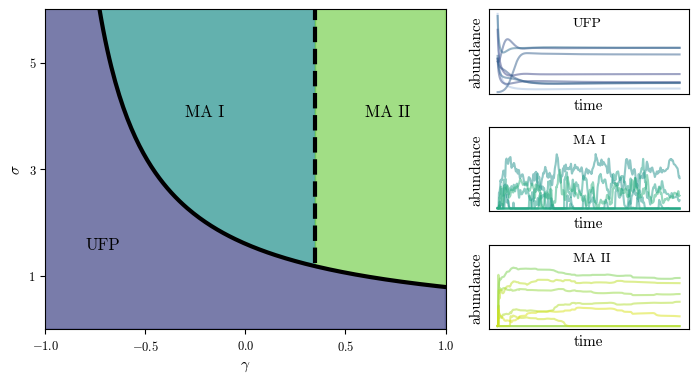

In [6]:
mu = -3
K = 0.1
K = 0.1

# Load Data
critical_line_df = pd.read_csv(folder_to_save_data + 'critical_line_mu{}_K{}.csv'.format(mu, K))
fixed_example = np.load(folder_to_save_data + 'mu-3_sigma1_gamma-0.9_K0.1.npz' )['x']
saltelli_example = np.load(folder_to_save_data + 'mu-3_sigma10_gamma0.9_K0.1.npz')['x']
volatile_example = np.load(folder_to_save_data + 'mu-3_sigma10_gamma0_K0.1.npz' )['x']

# Create figure with GridSpec layout
fig = plt.figure(figsize=(18/2.54, 10/2.54))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # Left: Phase Diagram, Right: Inserts

#choosing the color of each phase
colors = [0.2, 0.5, 0.8]
alpha = 0.7

#setting the seed
np.random.seed(1)

# ---- Left Panel: Phase Diagram ----
ax1 = plt.subplot(gs[0])
ax1.set_xlim([-1, 1])
ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
#ax1.set_yscale('log')
ax1.set_ylim([0, 6])

# Set y-ticks only at chosen values
ax1.set_yticks([1, 3, 5])
ax1.set_yticklabels([1, 3, 5])

ax1.set_xlabel(r'$\gamma$')
ax1.set_ylabel(r'$\sigma$')
ax1.set_zorder(0)

# Plot critical lines
ax1.plot(critical_line_df['gamma'], critical_line_df['sigma'], color='black', lw=3)

# Add vertical boundary at gamma = 0.35
ax1.plot([0.35, 0.35], [1.24, 20], color='black', linestyle='--', lw = 3)

# Define a large enough sigma range to fill the whole plot
sigma_min, sigma_max = 0, 11  

critical_line_gamma = np.concatenate([np.array([-1]), critical_line_df['gamma'].values])
critical_line_sigma = np.concatenate([np.array([sigma_max]), critical_line_df['sigma'].values])

# Fill different phase regions
ax1.fill_between(critical_line_gamma, 0, critical_line_sigma, color= cmap(colors[0]), alpha  = alpha)
# Identify the minimum gamma value from the critical line
min_gamma = critical_line_df['gamma'].min()
# Define a large enough sigma range to fill the whole plot
sigma_min, sigma_max = 0, 11  

ax1.fill_between(critical_line_df['gamma'][critical_line_df['gamma'] <= 0.35], 
                 critical_line_df['sigma'][critical_line_df['gamma'] <= 0.35], 20, 
                 color=cmap(colors[1]),
                 alpha = alpha
                 )
ax1.fill_between(critical_line_df['gamma'][critical_line_df['gamma'] >= 0.35], 
                 critical_line_df['sigma'][critical_line_df['gamma'] >= 0.35], 20, 
                 color=cmap(colors[2]),
                 alpha = alpha,
                 )
                    

# Add text labels for phases
ax1.text(-0.8, 1.5, "UFP", fontsize=12, fontweight='bold', color='black')   # Lower region
ax1.text(-0.3, 4, "MA I", fontsize=12, fontweight='bold', color='black')   # Upper left region
ax1.text(0.6, 4, "MA II", fontsize=12, fontweight='bold', color='black')  # Upper right region

# ---- Right Panel: Three Stacked Subplots ----
gs_right = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1], hspace=0.4)
examples = [fixed_example, volatile_example, saltelli_example]
titles = ["UFP", "MA I", "MA II"]
xs = [3300, 3300, 3300]
ys = [0.8, 112, 200]
ylims_max = [1, 140, 250]
ylims_min = [-0.005, -5, -10]


for i, (example_data, title, color) in enumerate(zip(examples, titles, colors)):
    ax = plt.subplot(gs_right[i])
    for j in range(8):  # Plot 8 example trajectories
        n = np.random.randint(0, example_data.shape[1])
        if i==0 and j==0:
            ax.plot(example_data[:, n], alpha=0.5, color='#a3bdde', label='Example trajectories')
        else:
            ax.plot(example_data[:, n], alpha=0.5, color=cmap(color + j * 0.02))
    
    ax.set_ylim([ylims_min[i], ylims_max[i]])
    ax.set_ylabel("abundance")
    ax.set_xlabel("time")
    ax.text(xs[i], ys[i], title)
    ax.set_xticks([]) # No X-ticks
    ax.set_yticks([]) # No Y-ticks

# Adjust layout and save
plt.tight_layout()
plt.savefig(folder_to_save_results + 'panel1.pdf')
plt.show()

## Panel 2 : Species Abundance Distribution (SAD)

### Panel 2 - Data

In [7]:
mu = -3
sigma = 1
gamma = 0
K = 0.8
mig = 1e-8

#Self-consistency solutions
initial_guess = [0.33025696, 0.32220374, 0.48581894]

# Solve the system numerically
solution = fsolve(equations_self_consistency, initial_guess, args = (mu, sigma, gamma, K))

Q = solution[0]
q = solution[1]
chi = solution[2]

#SAD
x_list = np.linspace(0, 10, 1000)
theo_SAD = SAD(x_list, mu, sigma, gamma, K, Q, q, chi )


#SIMULATIONS FOR COMPARISON
N_sim = 10
S = 1000
dt = 0.01
t = np.arange(0, 10_000)*dt

samples = np.zeros([N_sim*S])
for i in range(N_sim):
    alpha = inter_matrix(S, mu, sigma, gamma)
    x = np.random.uniform(0, 1, S)
    x = odeint(dynamics, x, t, args = (S, mu, sigma, gamma, K, 0, alpha))
    samples[i*S:(i+1)*S] = np.mean(x[-500:, :], axis = 0)


#saving the data
np.savez(folder_to_save_data + 'SAD_mu{}_sigma{}_gamma{}_K{}.npz'.format(mu, sigma, gamma, K), x_list = x_list, SAD = theo_SAD, samples = samples)

### Panel 2 - Plot

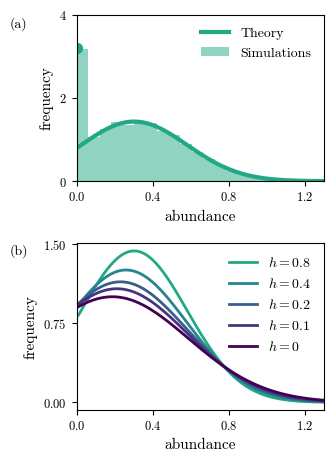

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(8.9/2.54, 12/2.54))

n_remove = 1 #number of points to not plot the extincted species part of the SAD

#loading the data

data_K0 = np.load(folder_to_save_data + 'SAD_mu-3_sigma1_gamma0_K0.npz')
x_list = data_K0['x_list']
theo_SAD_K0 = data_K0['SAD']

data_K01 = np.load(folder_to_save_data + 'SAD_mu-3_sigma1_gamma0_K0.1.npz')
x_list = data_K01['x_list']
theo_SAD_K01 = data_K01['SAD']
samples_K01 = data_K01['samples']

data_K02 = np.load(folder_to_save_data + 'SAD_mu-3_sigma1_gamma0_K0.2.npz')
x_list = data_K02['x_list']
theo_SAD_K02 = data_K02['SAD']

data_K04 = np.load(folder_to_save_data + 'SAD_mu-3_sigma1_gamma0_K0.4.npz')
x_list = data_K04['x_list']
theo_SAD_K04 = data_K04['SAD']

data_K08 = np.load(folder_to_save_data + 'SAD_mu-3_sigma1_gamma0_K0.8.npz')
x_list = data_K08['x_list']
theo_SAD_K08 = data_K08['SAD']
samples_K08 = data_K08['samples']


#plot a: comparison of data sample with theory

ax[0].plot(x_list[n_remove:], theo_SAD_K08[n_remove:], label = 'Theory', lw = 3, color = cmap(0.6))

n, bins, patches  = ax[0].hist(samples_K08, bins=25, density = True, alpha = 0.5, color = cmap(0.6), label = 'Simulations')
DeltaX = np.diff(bins)
ax[0].scatter(x_list[0], theo_SAD_K08[0]/np.diff(bins)[0]+np.sum(theo_SAD_K08[x_list<bins[1]][1:]*np.diff(x_list)[1])/(np.diff(bins)[0]),  color = cmap(0.6), s = 50)# label = 'Extinction')
ax[0].set_xlabel(r'abundance')
ax[0].set_ylabel(r'frequency')
ax[0].set_xlim([0, 1.3])
ax[0].set_ylim([0, 1])

ax[0].set_xticks([0, 0.4, 0.8, 1.2])
ax[0].set_yticks([0,2, 4])

ax[0].text(-0.35, 3.7,'(a)')
ax[0].legend(loc = 'upper right', frameon = False)

ax[1].plot(x_list[n_remove:], theo_SAD_K08[n_remove:], label = r'$h=0.8$', lw = 2, color = cmap(0.6))
ax[1].plot(x_list[n_remove:], theo_SAD_K04[n_remove:], label = r'$h=0.4$', lw = 2, color = cmap(0.45))
ax[1].plot(x_list[n_remove:], theo_SAD_K02[n_remove:], label = r'$h=0.2$', lw = 2, color = cmap(0.3))
ax[1].plot(x_list[n_remove:], theo_SAD_K01[n_remove:], label = r'$h=0.1$', lw = 2, color = cmap(0.15))
ax[1].plot(x_list[n_remove:], theo_SAD_K0[n_remove:], label = r'$h=0$', lw = 2, color = cmap(0))


ax[1].set_xlabel(r'abundance')
ax[1].set_ylabel(r'frequency')
ax[1].set_xlim([0, 1.3])
ax[1].legend(frameon=False, loc = 'upper right')
ax[1].set_xticks([0, 0.4, 0.8, 1.2])
ax[1].set_yticks([0, 0.75, 1.5])

ax[1].text(-0.35, 1.4,'(b)')

fig.tight_layout()
plt.savefig(folder_to_save_results + 'panel2.pdf')

## Panel 3 - Phase diagram

#### Panel 3 - Data

#### Panel 3 - Plot

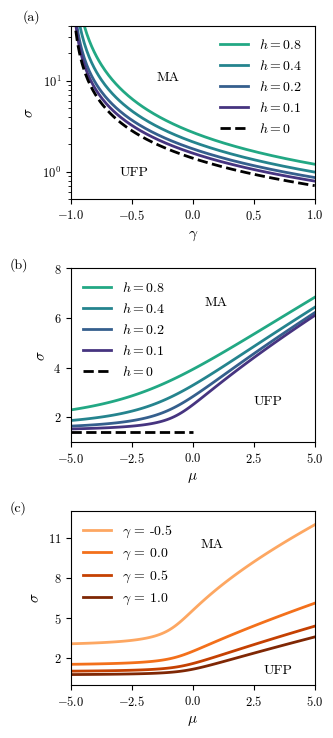

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(8.9/2.54, 19/2.54))

#gamma-sigma
df = pd.read_csv(folder_to_save_data + 'test_critical_line_gamma-sigma.csv')

for i, K in enumerate(np.unique(df['K'])[::-1]):
    ax[0].plot(df['gamma'][df['K']==K], df['sigma'][df['K']==K], lw = 2, label = r'$h = {}$'.format(K), color = cmap(0.6-i*0.15))


gamma_list = df['gamma'].unique()

ax[0].plot(gamma_list, np.sqrt(2/(1+gamma_list)**2), lw = 2, label = r'$h = 0$', color = 'black', linestyle = '--')

ax[0].set_xlabel(r'$\gamma$')
ax[0].set_ylabel(r'$\sigma$')
ax[0].legend(frameon = False)

ax[0].set_xlim([-1, 1])
ax[0].set_ylim([0.5, 40])
ax[0].set_yscale('log')
ax[0].set_xticks([-1, -0.5, 0, 0.5, 1])
ax[0].text(-1.4, 46, '(a)')
#ax[0].text(0.7, 7.5, r'$\mu$ = {}'.format(mu))


#mu-sigma changing gamma
df = pd.read_csv(folder_to_save_data + 'critical_line_mu-sigma_changing_gamma.csv')

cmap2 = plt.get_cmap('Oranges')

for i,gamma in enumerate(np.unique(df['gamma'])[1:]):
    ax[2].plot(df['mu'][df['gamma']==gamma], df['sigma'][df['gamma']==gamma], lw = 2, label = r'$\gamma$ = {}'.format(gamma), color = cmap2(0.4+i*0.2))

ax[2].set_xlabel(r'$\mu$')
ax[2].set_ylabel(r'$\sigma$')


ax[2].legend(frameon = False)
ax[2].set_xlim([-5, 5])
ax[2].set_xticks([-5, -2.5, 0, 2.5, 5])
ax[2].set_yticks([2, 5, 8, 11])
ax[2].set_ylim([0, 13])
ax[2].text(-7.5, 13, '(c)')

#mu-sigma changing K
df = pd.read_csv(folder_to_save_data + 'critical_line_mu-sigma_changing_K.csv')

ax[1].set_xlabel(r'$\mu$')
ax[1].set_ylabel(r'$\sigma$')

#Plot
for i,K in enumerate(np.unique(df['K'])[::-1]):
    ax[1].plot(df['mu'][df['K']==K], df['sigma'][df['K']==K], lw = 2, label = r'$h = {}$'.format(K),  color = cmap(0.6-i*0.15))


ax[1].plot(np.linspace(-5, 0, 100), np.sqrt(2)*np.ones(100), lw = 2, label = r'$h = 0$', color = 'black', linestyle = '--')
ax[1].legend(frameon = False)
ax[1].set_xlim([-5, 5])
ax[1].set_xticks([-5, -2.5, 0, 2.5, 5])
ax[1].set_ylim([1, 8])
ax[1].set_yticks([2, 4, 6, 8])
ax[1].text(-7.5, 8, '(b)')


# Add 'MA' above and 'UFP' below a representative line
ax[0].text(-0.3, 10, 'MA')#, verticalalignment='bottom', horizontalalignment='center')
ax[0].text(-0.6, 0.9, 'UFP')#, verticalalignment='top', horizontalalignment='center')

ax[1].text(0.5, 6.5, 'MA')# fontsize=10 verticalalignment='bottom', horizontalalignment='center')
ax[1].text(2.5, 2.5, 'UFP')#, fontsize=10, verticalalignment='top', horizontalalignment='center')


ax[2].text(0.8, 10.0, 'MA', fontsize=10, verticalalignment='bottom', horizontalalignment='center')
ax[2].text(3.5, 1.5, 'UFP', fontsize=10, verticalalignment='top', horizontalalignment='center')

fig.tight_layout()
plt.savefig(folder_to_save_results + 'panel3.pdf')

## Panel 4 - Numerical characterization of the dynamical phases

#### Panel 4 - Data

#### Panel 4 - Plot

#### Two column-version

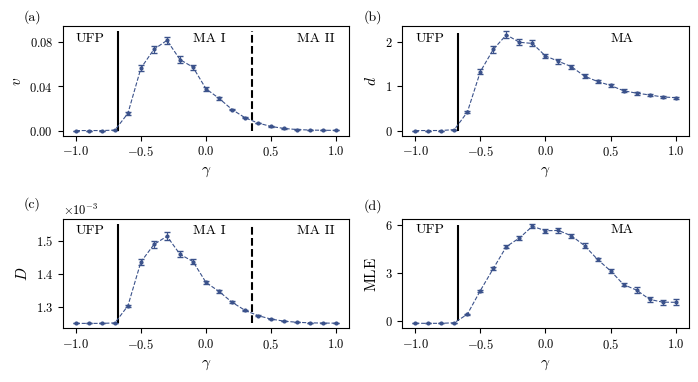

In [10]:
mu = -3
sigma = 5
K = 0.1

#choosing the color
color = cmap(0.25)


#loading the data
df = pd.read_csv(folder_to_save_data + 'numerical_characterization_mu{}_sigma{}_K{}.csv'.format(mu, sigma, K))
df2 = df.groupby('gamma').mean()
df3 = df.groupby('gamma').std()


fig, ax = plt.subplots(2, 2,  figsize = (18/2.54, 10/2.54))

ax[0, 0].errorbar(df2.index, df2['h'], df3['h']/15, linestyle= '--', lw = 0.8, marker = '.', markersize = 4, capsize = 2, label = 'h', color = color)
ax[0, 0].set_xlabel(r'$\gamma$')
ax[0, 0].set_ylabel(r'$v$')
ax[0, 0].set_yticks([0, 0.04, 0.08])
ax[0, 0].vlines(x = -0.675, ymin = 0, ymax = 0.09, color = 'black', linestyle = '-')
ax[0, 0].vlines(x = 0.35, ymin = 0, ymax = 0.09, color = 'black', linestyle = '--')
ax[0, 0].text(-1.4, 0.1, '(a)')

ax[0, 1].errorbar(df2.index, df2['d'], df3['d']/15,  linestyle= '--', lw = 0.8, marker = '.', markersize = 4, capsize = 2,  label = 'd', color = color)
ax[0, 1].set_xlabel(r'$\gamma$')
ax[0, 1].set_ylabel(r'$d$')
ax[0, 1].set_yticks([0, 1, 2])
ax[0, 1].vlines(x = -0.675, ymin = 0, ymax = 2.2, color = 'black', linestyle = '-')
ax[0, 1].text(-1.4, 2.48, '(b)')


ax[1, 0].errorbar(df2.index, df2['dim'], df3['dim']/15,  linestyle= '--', lw = 0.8, marker = '.', markersize = 4, capsize = 2,  color= color)
ax[1, 0].set_xlabel(r'$\gamma$')
ax[1, 0].set_ylabel(r'$D$')
ax[1, 0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1, 0].vlines(x = -0.675, ymin = 0.00125, ymax = 0.00155, color = 'black', linestyle = '-')
ax[1, 0].vlines(x = 0.35, ymin = 0.00125, ymax = 0.00155, color = 'black', linestyle = '--')
ax[1, 0].text(-1.4, 0.0016, '(c)')

ax[1, 1].errorbar(df2.index, df2['mle'], df3['mle']/15,  linestyle= '--', lw = 0.8, marker = '.', markersize = 4, capsize = 2,  label = 'MLE', color = color)
ax[1, 1].set_xlabel(r'$\gamma$')
ax[1, 1].set_ylabel(r'$\text{MLE}$')
ax[1, 1].set_yticks([0, 3, 6])
ax[1, 1].vlines(x = -0.675, ymin = 0, ymax = 6, color = 'black', linestyle = '-')
ax[1, 1].text(-1.4, 7, '(d)')

ax[0,0].text(-1, 0.08, 'UFP')
ax[0,0].text(-0.1, 0.08, 'MA I')
ax[0,0].text(0.7, 0.08, 'MA II')


ax[0,1].text(-1, 2, 'UFP')
ax[0,1].text(0.5, 2, 'MA')

ax[1,0].text(-1, 0.00152, 'UFP')
ax[1,0].text(-0.1, 0.00152, 'MA I')
ax[1,0].text(0.7, 0.00152, 'MA II')


ax[1,1].text(-1, 5.5, 'UFP')
ax[1,1].text(0.5, 5.5, 'MA')

fig.tight_layout()
plt.savefig(folder_to_save_results + 'panel4.pdf')